# Inference

- Run inference on the test dataset.
- Mainly for testing your model is doing ok visually.

In [19]:
%env CUDA_VISIBLE_DEVICES=1
%load_ext autoreload
%autoreload 2
from pathlib import Path

import matplotlib.pyplot as plt
import tqdm
import torch
import numpy as np

import sys; sys.path.append("../")
import maskflow

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/C_elegans")
data_dir = root_dir / "Data"
model_dir = root_dir / "Models"

# Import the configuration associated with this dataset and network.
config = maskflow.config.load_config(root_dir / "config.yaml")

env: CUDA_VISIBLE_DEVICES=1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# Select the model
model_name = '2018.11.10-19:01:52'
model_path = model_dir / model_name

# Set some configurations
config['MODEL']['DEVICE'] = "cuda"
config['DATALOADER']['NUM_WORKERS'] = 4
config['TEST']['IMS_PER_BATCH'] = 6
config['SOLVER']['IMS_PER_BATCH'] = 6
batch_to_load = 2

# Build the model
model = maskflow.inference.build_model(config, model_path)

# Load some data
data_loader = maskflow.dataset.get_data_loader(config, data_dir, is_train=False)
data = [datum for _, datum in zip(range(batch_to_load), data_loader)]

# Retrieve category's names
categories = data_loader.dataset.coco.cats

# Run inference
predictions = []
images = []
ground_truth = []
for batch_image, batch_target, batch_idx in data:
    batch_image = batch_image.to(config['MODEL']['DEVICE'])
    with torch.no_grad():
        prediction = model(batch_image)
        prediction = [o.to('cpu') for o in prediction]
        predictions.extend(prediction)
        images.extend([im for im in batch_image.tensors])
        ground_truth.extend(batch_target)
        
images = np.array([o.to('cpu').numpy() for o in images])
len(images)

2018-11-10 19:08:17,486:INFO:maskrcnn_benchmark.utils.checkpoint: Loading checkpoint from /home/hadim/.data/Neural_Network/Maskflow/C_elegans/Models/2018.11.10-19:01:52/model_0000100.pth
2018-11-10 19:08:17,819:WARNING:maskrcnn_benchmark.data.build: When using more than one image per GPU you may encounter an out-of-memory (OOM) error if your GPU does not have sufficient memory. If this happens, you can reduce SOLVER.IMS_PER_BATCH (for training) or TEST.IMS_PER_BATCH (for inference). For training, you must also adjust the learning rate and schedule length according to the linear scaling rule. See for example: https://github.com/facebookresearch/Detectron/blob/master/configs/getting_started/tutorial_1gpu_e2e_faster_rcnn_R-50-FPN.yaml#L14


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


12

15
tensor([0.9992, 0.9891, 0.9847, 0.9735, 0.9650, 0.9577, 0.9565, 0.9340, 0.8902,
        0.8416, 0.8402, 0.7791, 0.7309, 0.7099, 0.7093])


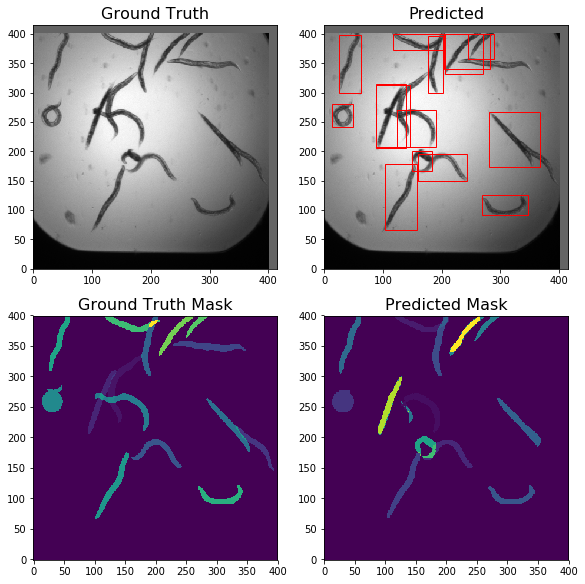

In [21]:
# Show prediction
idx = 3
image = images[idx]
prediction = predictions[idx]
gt = ground_truth[idx]

prediction = maskflow.inference.select_top_predictions(prediction, confidence_threshold=0.7)

print(prediction.bbox.shape[0])
print(prediction.get_field('scores'))

_ = maskflow.viz.display_prediction_and_gt(image, prediction, gt,
                                           class_names=config['CLASS_NAMES'],
                                           pixel_mean=config['INPUT']['PIXEL_MEAN'],
                                           pixel_std=config['INPUT']['PIXEL_STD'])